# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


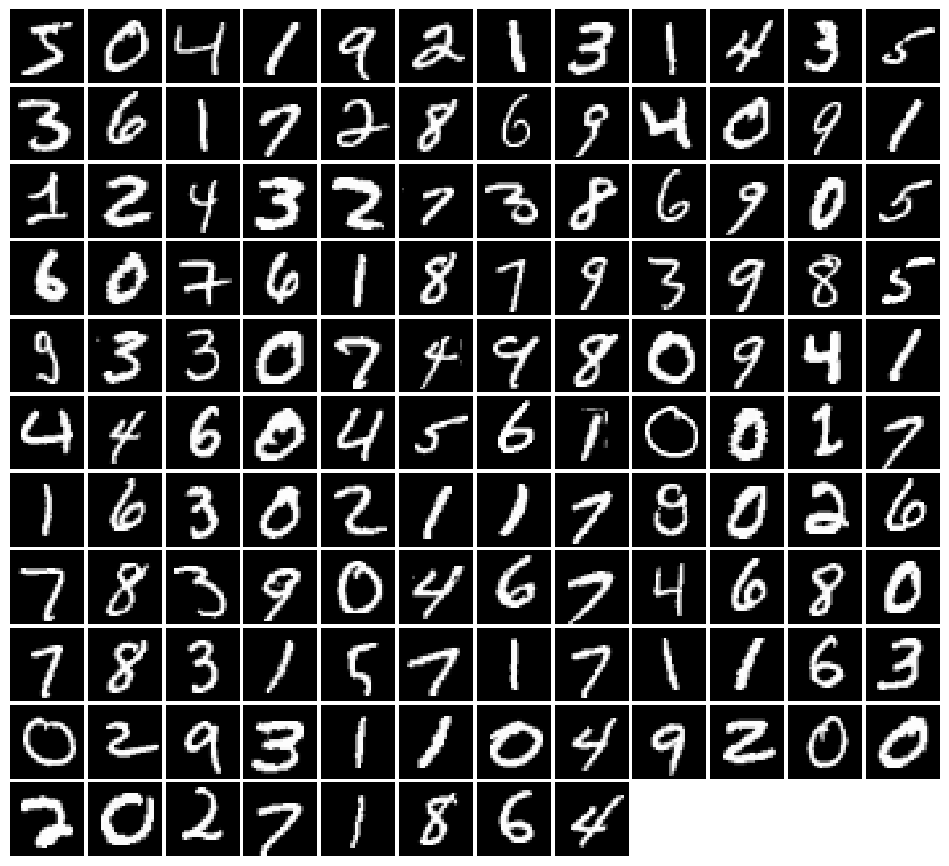

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = next(loader_train.__iter__())[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        #print(x.size())
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        Flatten(),
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )
    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

EPOCH:  1
Iter: 0, D: 1.075, G:0.7067



Iter: 250, D: 0.8782, G:0.7767



EPOCH:  2
Iter: 500, D: 0.6387, G:1.236


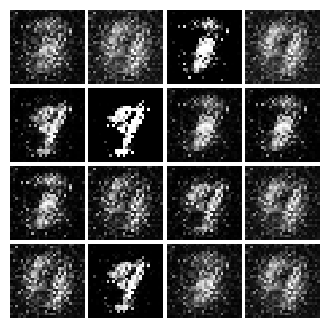


Iter: 750, D: 0.6961, G:0.7662



EPOCH:  3
Iter: 1000, D: 0.7888, G:0.8845


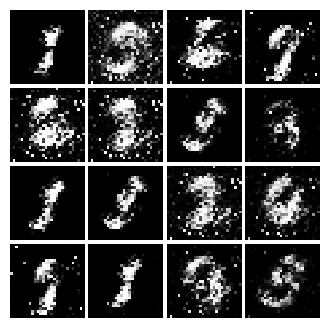


Iter: 1250, D: 0.8199, G:0.6388


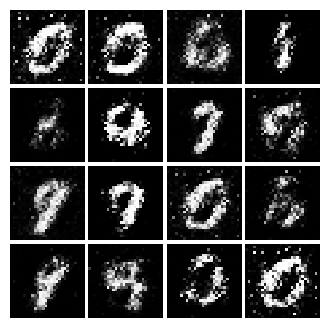


EPOCH:  4
Iter: 1500, D: 0.8539, G:0.5891


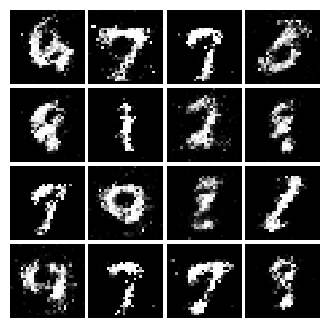


Iter: 1750, D: 0.871, G:0.5825


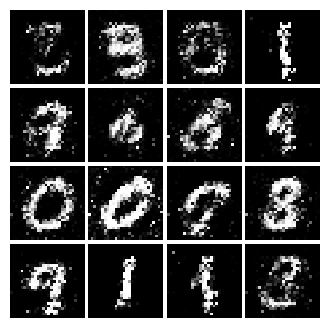


EPOCH:  5
Iter: 2000, D: 0.8173, G:0.6282



Iter: 2250, D: 0.8182, G:0.6083


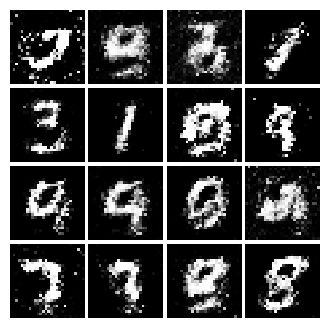


EPOCH:  6
Iter: 2500, D: 0.8561, G:0.5923



Iter: 2750, D: 0.9177, G:0.5561



EPOCH:  7
Iter: 3000, D: 0.8945, G:0.626



Iter: 3250, D: 0.8876, G:0.7128



EPOCH:  8
Iter: 3500, D: 0.8465, G:0.6357


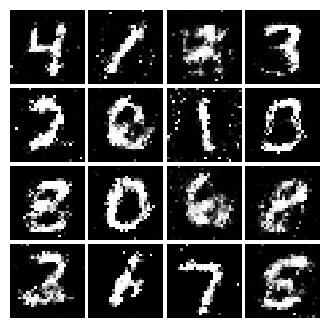


EPOCH:  9
Iter: 3750, D: 0.8732, G:0.6385


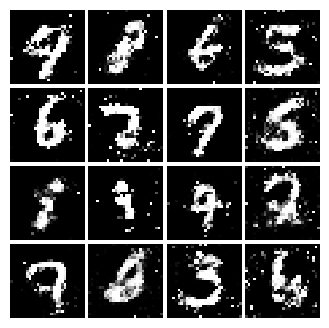


Iter: 4000, D: 0.8904, G:0.5725


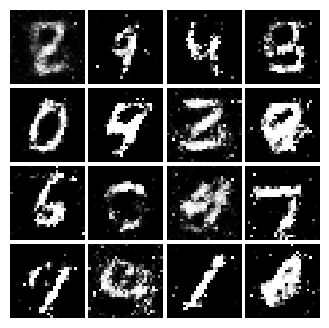


EPOCH:  10
Iter: 4250, D: 0.8972, G:0.5582


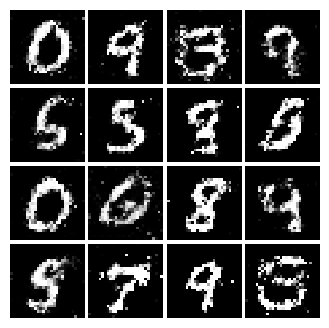


Iter: 4500, D: 0.8143, G:0.6623


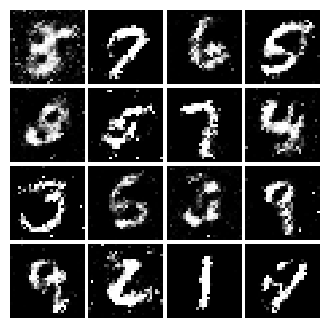

In [8]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1
Iter: 0, D: 0.5373, G:0.4831



Iter: 250, D: 0.08731, G:0.5421


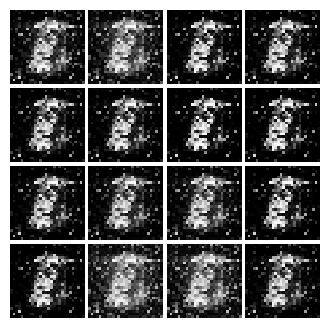


EPOCH:  2
Iter: 500, D: 0.1249, G:0.3066



Iter: 750, D: 0.1455, G:0.2887



EPOCH:  3
Iter: 1000, D: 0.1253, G:0.2743


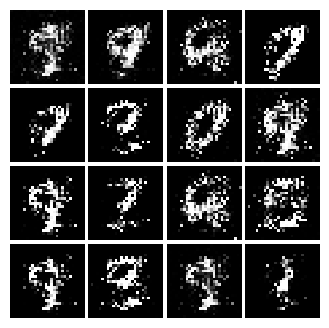


Iter: 1250, D: 0.1761, G:0.2999


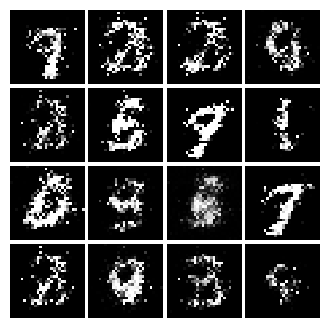


EPOCH:  4
Iter: 1500, D: 0.1738, G:0.2707



Iter: 1750, D: 0.1993, G:0.2235



EPOCH:  5
Iter: 2000, D: 0.2289, G:0.2293



Iter: 2250, D: 0.2015, G:0.1897



EPOCH:  6
Iter: 2500, D: 0.2176, G:0.1755


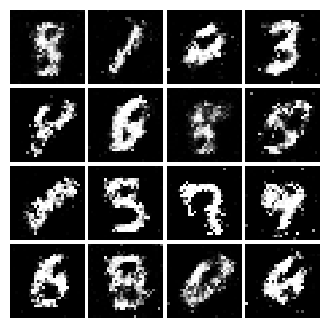


Iter: 2750, D: 0.2392, G:0.2469


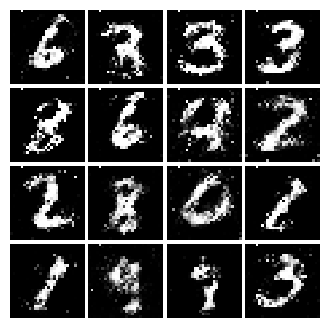


EPOCH:  7
Iter: 3000, D: 0.2122, G:0.2407



Iter: 3250, D: 0.1868, G:0.2085



EPOCH:  8
Iter: 3500, D: 0.2356, G:0.1498



EPOCH:  9
Iter: 3750, D: 0.2393, G:0.1754



Iter: 4000, D: 0.2274, G:0.1425


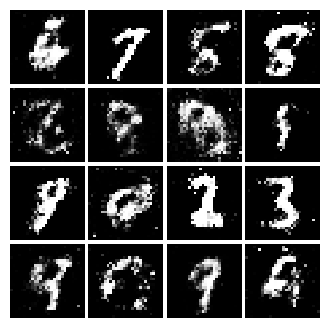


EPOCH:  10
Iter: 4250, D: 0.2274, G:0.1637


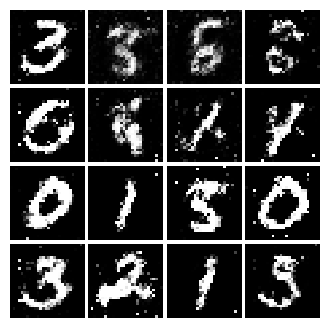


Iter: 4500, D: 0.2429, G:0.126


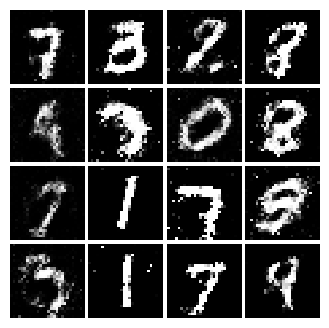

In [9]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)